# For this Project, I will be using the 2024 World Happiness Report

## This report review the state of happiness in the world today and show how the new science of happiness explains personal and national variations in happiness.
## The report can be found at: https://www.kaggle.com/datasets/jainaru/world-happiness-report-2024-yearly-updated

## Columns Description:
- **Country Name**: Name of the country
- **Regional Indicator**: Region to which the country belongs
- **Ladder Score**: The happiness score for each country, with the best possible life for them being a 10, and the worst possible life being a 0.
- **Upper whisker**: Upper bound of the happiness score
- **Lower whisker**: Lower bound of the happiness score
- **Log GDP per capita**: The natural logarithm of the country's GDP per capita
- **Social support**: The national average of binary responses(either 0 or 1 representing No/Yes) to the question about having relatives or friends to count on in times of trouble
- **Healthy life expectancy**: The average number of years a newborn infant would live in good health
- **Freedom to make life choices**: The national average of responses to the question about satisfaction with freedom to choose what to do with one's life.
- **Generosity**: The residual of regressing the national average of responses to the question about donating money to charity on GDP per capita.
- **Perceptions of corruption**: The perceived extent of corruption in the government and businesses.
- **Dystopia + residual**: Dystopia is an imaginary country with the world’s least-happy people, used as a benchmark for comparison. The dystopia + residual score is a combination of the Dystopia score and the unexplained residual for each country
- **Positive affect**: The national average of responses to questions about positive emotions experienced yesterday.
- **Negative affect**: The national average of responses to questions about negative emotions experienced yesterday.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV

In [12]:
df = pd.read_csv("world_happiness_2024.csv")
df.head()

,Country name,Regional indicator,Ladder score,upperwhisker,lowerwhisker,Log GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.741,7.815,7.667,1.844,1.572,0.695,0.859,0.142,0.546,2.082
1,Denmark,Western Europe,7.583,7.665,7.500,1.908,1.520,0.699,0.823,0.204,0.548,1.881
2,Iceland,Western Europe,7.525,7.618,7.433,1.881,1.617,0.718,0.819,0.258,0.182,2.050
3,Sweden,Western Europe,7.344,7.422,7.267,1.878,1.501,0.724,0.838,0.221,0.524,1.658
4,Israel,Middle East and North Africa,7.341,7.405,7.277,1.803,1.513,0.740,0.641,0.153,0.193,2.298


In [13]:
# 1. Identify columns with missing values
missing_cols = df.columns[df.isnull().any()]
print("Columns with missing values:", list(missing_cols))

# 2. Replace missing values in each numeric column with the mean
for col in missing_cols:
    if pd.api.types.is_numeric_dtype(df[col]):
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)

# 3. Drop duplicate rows
df.drop_duplicates(inplace=True)

# Display first 5 rows to check the cleaned data
print(df.head())


Columns with missing values: ['Log GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Dystopia + residual']
  Country name            Regional indicator  Ladder score  upperwhisker  \
0      Finland                Western Europe         7.741         7.815   
1      Denmark                Western Europe         7.583         7.665   
2      Iceland                Western Europe         7.525         7.618   
3       Sweden                Western Europe         7.344         7.422   
4       Israel  Middle East and North Africa         7.341         7.405   

   lowerwhisker  Log GDP per capita  Social support  Healthy life expectancy  \
0         7.667               1.844           1.572                    0.695   
1         7.500               1.908           1.520                    0.699   
2         7.433               1.881           1.617                    0.718   
3         7.267             

In [15]:
# Compute correlation matrix with respect to 'Ladder Score'
correlations = df.corr(numeric_only=True)['Ladder score'].sort_values(ascending=False)

# Exclude 'Ladder Score' itself and get top 5 correlated attributes
top_5_attributes = correlations.drop('Ladder score').head(5)

print("Top 5 attributes with highest correlation to Ladder Score:")
print(top_5_attributes)

Top 5 attributes with highest correlation to Ladder Score:
lowerwhisker               0.999697
upperwhisker               0.999678
Social support             0.812142
Log GDP per capita         0.767181
Healthy life expectancy    0.758352
Name: Ladder score, dtype: float64


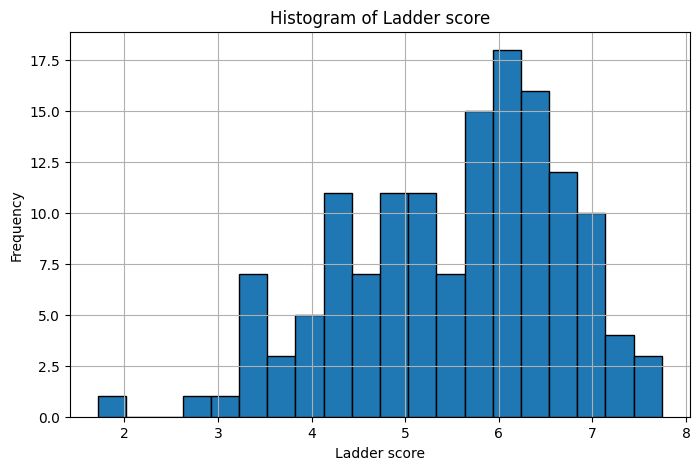

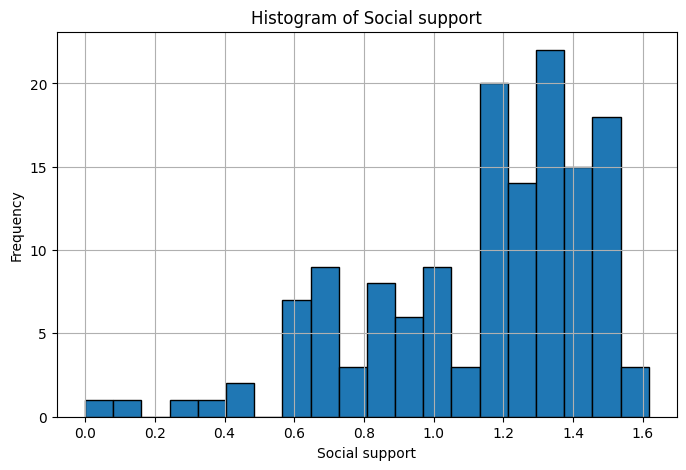

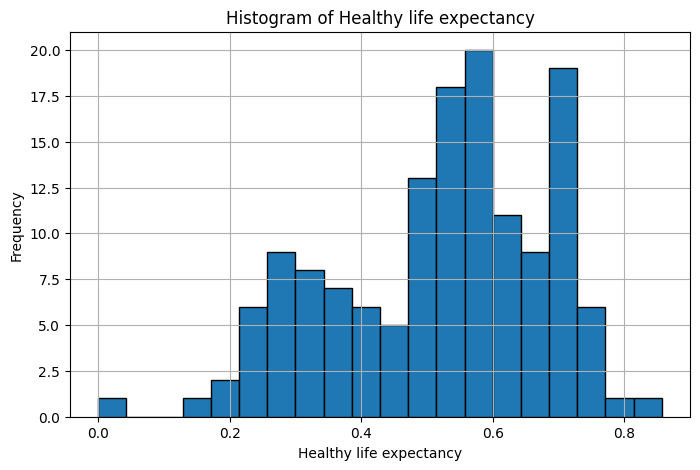

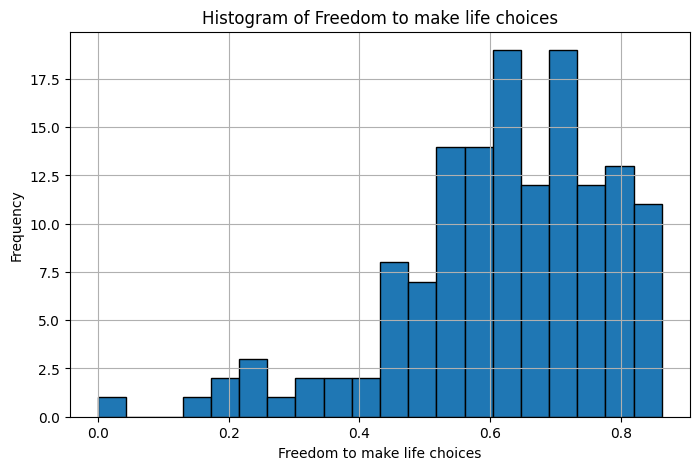

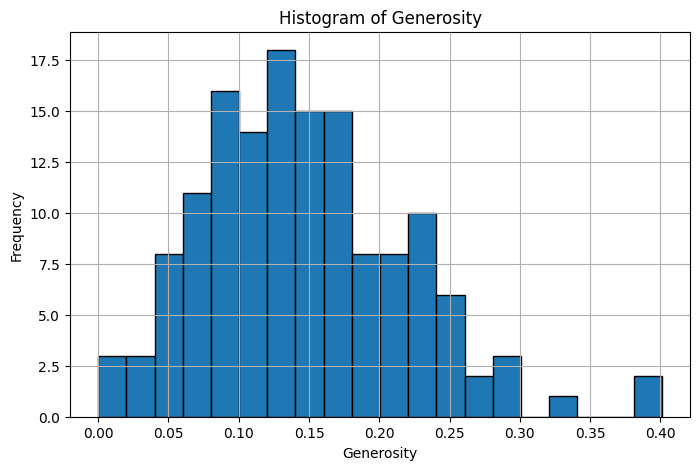

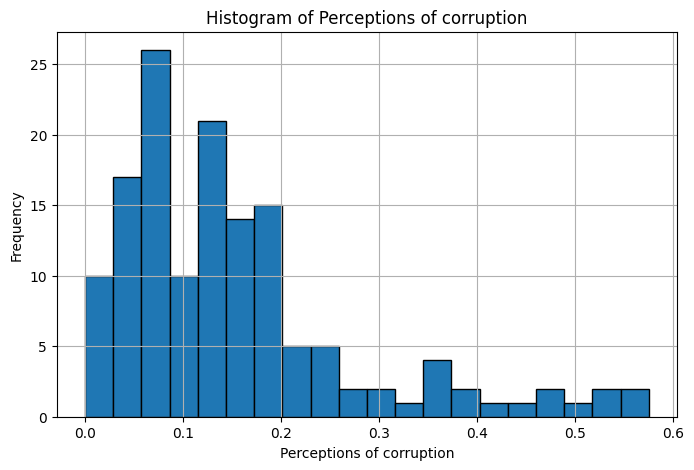

In [16]:
# List of key variables you want to analyze
key_variables = [
    'Ladder score', 
    'Logged GDP per capita', 
    'Social support', 
    'Healthy life expectancy', 
    'Freedom to make life choices', 
    'Generosity', 
    'Perceptions of corruption'
]

# Plot histograms for each key variable
for var in key_variables:
    if var in df.columns:
        plt.figure(figsize=(8, 5))
        plt.hist(df[var].dropna(), bins=20, edgecolor='black')
        plt.title(f'Histogram of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    else:
        print(f"Warning: Column '{var}' not found in the DataFrame.")

In [17]:
# List of variables for outlier analysis
variables = [
    'Ladder score', 
    'Logged GDP per capita', 
    'Social support', 
    'Healthy life expectancy', 
    'Freedom to make life choices', 
    'Generosity', 
    'Perceptions of corruption'
]

# Dictionary to keep track of outlier counts
outlier_counts = {}

# DataFrame to store all outlier rows
outlier_rows = pd.DataFrame()

for var in variables:
    if var in df.columns:
        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Find outliers
        outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
        
        # Count and store
        outlier_counts[var] = outliers.shape[0]
        
        # Add to outlier_rows dataframe
        outlier_rows = pd.concat([outlier_rows, outliers])
        
        print(f"\nOutliers for '{var}':")
        print(outliers[[var]])
    else:
        print(f"\nColumn '{var}' not found in the DataFrame.")

# Drop duplicate rows since the same row might be an outlier in multiple columns
outlier_rows = outlier_rows.drop_duplicates()

# Summary
print("\nSummary of outlier counts per column:")
for var, count in outlier_counts.items():
    print(f"- {var}: {count} outliers")


Outliers for 'Ladder score':
     Ladder score
142         1.721

Column 'Logged GDP per capita' not found in the DataFrame.

Outliers for 'Social support':
     Social support
115           0.128
142           0.000

Outliers for 'Healthy life expectancy':
     Healthy life expectancy
140                      0.0

Outliers for 'Freedom to make life choices':
     Freedom to make life choices
97                          0.202
131                         0.172
141                         0.173
142                         0.000

Outliers for 'Generosity':
     Generosity
79        0.399
117       0.401

Outliers for 'Perceptions of corruption':
    Perceptions of corruption
0                       0.546
1                       0.548
3                       0.524
6                       0.484
7                       0.432
8                       0.498
10                      0.480
16                      0.418
29                      0.575
33                      0.401
85                

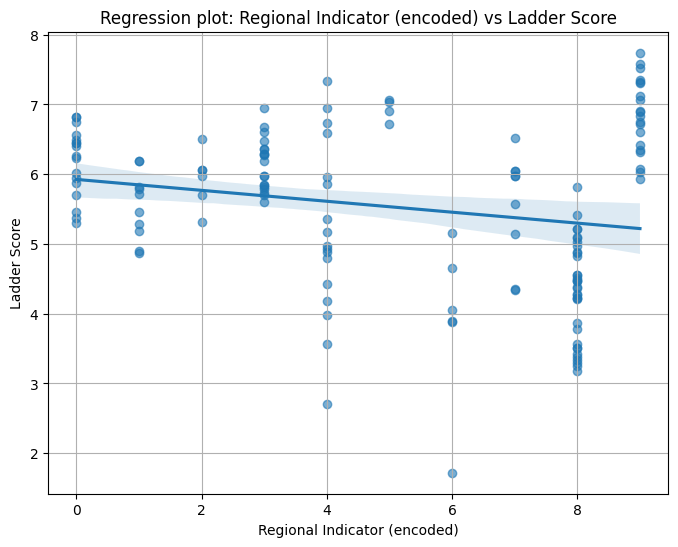

In [19]:
# Encode Regional indicator as numeric codes
df['Region_code'] = df['Regional indicator'].cat.codes

# Plot regression
plt.figure(figsize=(8,6))
sns.regplot(x='Region_code', y='Ladder score', data=df, scatter_kws={'alpha':0.6})
plt.title('Regression plot: Regional Indicator (encoded) vs Ladder Score')
plt.xlabel('Regional Indicator (encoded)')
plt.ylabel('Ladder Score')
plt.grid(True)
plt.show()

In [21]:
# Prepare X and y
X = df[['Healthy life expectancy']].dropna()
y = df.loc[X.index, 'Ladder score']

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate R^2
r2 = r2_score(y, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred)

print(f"R² (coefficient of determination): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

R² (coefficient of determination): 0.5751
Mean Squared Error (MSE): 0.5783


In [23]:
# Select relevant features
features = ['Regional indicator', 'Log GDP per capita', 'Social support', 'Perceptions of corruption']

# Drop rows with missing values in selected columns or Ladder score
df_clean = df[features + ['Ladder score']].dropna()

# One-hot encode Regional indicator
df_encoded = pd.get_dummies(df_clean, columns=['Regional indicator'], drop_first=True)

# Prepare X and y
X = df_encoded.drop(columns=['Ladder score'])
y = df_encoded['Ladder score']

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate R²
r2 = r2_score(y, y_pred)

# Calculate MSE
mse = mean_squared_error(y, y_pred)

print(f"R² (coefficient of determination): {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")

R² (coefficient of determination): 0.7992
Mean Squared Error (MSE): 0.2732


In [26]:
# Select features and target
features = ['Log GDP per capita', 'Social support', 'Perceptions of corruption']
target = 'Ladder score'

# Drop missing values
df_clean = df[features + [target]].dropna()

# Prepare X and y
X = df_clean[features]
y = df_clean[target]

# Split into train and test sets (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

# Create and fit Ridge regression model
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_train, y_train)

# Predict on test data
y_pred = ridge_model.predict(X_test)

# Calculate MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE) on test data: {mse:.4f}")
print(f"R² (coefficient of determination) on test data: {r2:.4f}")

Mean Squared Error (MSE) on test data: 0.3322
R² (coefficient of determination) on test data: 0.6111


In [29]:
# Select features and target
features = ['Log GDP per capita', 'Social support', 'Perceptions of corruption']
target = 'Ladder score'

# Drop missing values
df_clean = df[features + [target]].dropna()

X = df_clean[features]
y = df_clean[target]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

# Apply second-degree polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Set up grid search
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
grid_search = GridSearchCV(
    ridge, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)
grid_search.fit(X_train_poly, y_train)

# Create DataFrame to summarize results
results_df = pd.DataFrame(grid_search.cv_results_)[['param_alpha', 'mean_test_score', 'std_test_score']]

# Convert negative MSE to positive for easier interpretation
results_df['mean_test_MSE'] = -results_df['mean_test_score']
results_df = results_df.drop(columns='mean_test_score')

# Sort by mean_test_MSE
results_df = results_df.sort_values(by='mean_test_MSE')

print("Grid Search Cross-Validation Results:")
print(results_df)

# Report best parameter
best_alpha = grid_search.best_params_['alpha']
print(f"\nBest alpha selected by GridSearchCV: {best_alpha}")

# Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_poly)

test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"\nPerformance on test data using best Ridge model:")
print(f"- Mean Squared Error (MSE): {test_mse:.4f}")
print(f"- R² (coefficient of determination): {test_r2:.4f}")

Grid Search Cross-Validation Results:
   param_alpha  std_test_score  mean_test_MSE
2         1.00        0.086546       0.372369
3        10.00        0.109147       0.380245
1         0.10        0.078584       0.382335
0         0.01        0.072519       0.385136
4       100.00        0.172518       0.496499

Best alpha selected by GridSearchCV: 1

Performance on test data using best Ridge model:
- Mean Squared Error (MSE): 0.3449
- R² (coefficient of determination): 0.5963
